## Background / Motivation

Chicago is often deemed one of the most dangerous cities in the United States, and people are typically concerned with this issue when visiting or living in the city. As the four of us are students at Northwestern—in close proximity with Chicago—we frequent the city ourselves, and have personally witnessed crimes committed. For example, on the Red Line, a common mode of transportation for many Chicago residents and tourists, there are many visible crimes that scare people away from using the subway. 
Therefore, we were interested in analyzing crimes in Chicago in order to see which types of crimes we should be more vigilant of, or where in Chicago we should practice extra caution. These analyses are crucial to our safety and the safety of others like us, who share similar experiences. Additionally, police inequality or inefficient allocation of resources in policing has been a prevalent issue in the United States recently, so we wanted to explore potential areas of disparity. 


## Problem statement 

1. Alyssa's question looks at how types of crime is distributed throughout the day. At various hours of the day, it is expected that crime characteristics will vary. We wanted to know which types of crimes are most common in the day-time vs. night-time, where crimes are commonly committed, and whether or not they are violent.  

2. Grace Chang's question examines theft, the most common type of crime, accounting for around 23% of total crimes, in further detail. We were interested in how theft was distributed across the various community areas of Chicago (e.g. The Loop), and how the population density of these areas relates to their respective theft rates. 

3. Grace Shao's question explores the most dangerous stations and community areas to ride the CTA in. We wanted to know the typical profiles of CTA crimes, specifically, where they are committed, whether they are committed on the train or platform, and which time of day to avoid certain stations. 

4. Paisley's question examines associations between the proportion of crimes that were arrested and the location in the city of Chicago, particularly in regards to police districts. How does the arrest proportion fluctuate depending on what part of the city the crime occurs in?

## Data sources

#### Primary Dataset:
To conduct our analysis, our primary dataset was Chicago crime data for 2022 as reported by the city of Chicago: https://data.cityofchicago.org/Public-Safety/Crimes-2022/9hwr-2zxp 

The data reports 239,043 observations of crimes in the city of Chicago (at the time of download, as this data is being updated to this day), and information about the crime such as its location, time/date, and whether or not the crime resulted in arrest. 

#### Supporting datasets include:
-  Chicago community areas by numeric code, population, area, and population density: https://en.wikipedia.org/wiki/Community_areas_in_Chicago 
    - Since the original dataset includes the numeric code of the community areas, to make our analysis more usable and readable, we merged the two datasets to include community area names. 

* IUCR codes https://data.cityofchicago.org/widgets/c7ck-438e 
    * Used in Alyssa’s analysis solely as reference to find violent crime type IUCR codes but not actually merged with data.

- CTA stations coordinates: https://data.cityofchicago.org/Transportation/CTA-System-Information-List-of-L-Stops/8pix-ypme 
    - The latitude and longitude columms are used to find the nearest subway station of each crime.

* Police sentiment data via the city of Chicago: https://data.cityofchicago.org/Public-Safety/Police-Sentiment-Scores/28me-84fj/data
    * This dataset is a compilation of collected survey data about residents’ feeling towards police based on their responses to 4 questions: 1) rating the safety of their neighborhood, 2) rating how they feel the police in their neighborhood listen to concerns of local residents, 3) rating how well the police in their neighborhood treat local residents with respect, and 4) rating trust in their police. (Note: responses were scored on a scale of 1-10, and the data is compiled to multiply scores by 10 so an average rating of 60 in the dataset corresponds to an average score of 6)


## Stakeholders
Our primary purpose is to help stakeholders understand crime in the city of Chicago. This understanding helps general parties make better choices to promote public and personal safety.

* Chicago residents/visitors: Residents and visitors will benefit from our analysis by using our recommendations to more safely navigate the city and transit stations and make housing decisions. 

* Police force: For the police force, we hope our analysis can give them direction on how to better serve and satisfy communities across districts and determine where to focus resources to create a safer Chicago. 


## Data quality check / cleaning / preparation 

In a tabular form, show the distribution of values of each variable used in the analysis - for both categorical and continuous variables. Distribution of a categorical variable must include the number of missing values, the number of unique values, the frequency of all its levels. If a categorical variable has too many levels, you may just include the counts of the top 3-5 levels. 

Were there any potentially incorrect values of variables that required cleaning? If yes, how did you clean them? 

Did your analysis require any other kind of data preparation before it was ready to use?

In [43]:
#| echo: false
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

In [44]:
#| echo: false
raw_crime_data = pd.read_csv("crimes_-_2022.csv")
raw_crime_data['Date'] = raw_crime_data['Date'].apply(pd.to_datetime)

In [46]:
#| echo: false
time_data = raw_crime_data.dropna(subset = ['Location Description'])
theft_data = raw_crime_data.loc[(raw_crime_data['Primary Type'] == 'THEFT'), :]
community_areas = pd.read_html('https://en.wikipedia.org/wiki/Community_areas_in_Chicago', match = 'Chicago community areas by number, population, and area')
community_areas = community_areas[0]
community_areas.columns = [col[0] for col in community_areas.columns]
community_areas.columns = ["No.", "Community Name", "Population", "Area (sqmi)", "Area (sqkm)", "Density (sqmi)", "Density (sqkm)"]

theft_data.loc[:,'Community Area'] = theft_data['Community Area'].apply(lambda x: f'{int(x):02d}' if isinstance(x, (int, str)) and str(x).isdigit() else x)
theft_data['Community Area'].value_counts().head(6) # Checking that the single digit codes were indeed converted to double digit format

theft_data.loc[:,'Community Area'] = theft_data['Community Area'].astype(str)
theft_community_data = theft_data.merge(community_areas, left_on = 'Community Area', right_on = 'No.', how = 'left')
theft_community_data['Community Name'] = theft_community_data['Community Name'].apply(lambda x: x.replace('(The) Loop[11]', 'The Loop'))

arrest_data = raw_crime_data.copy()
arrest_data['Side'] = arrest_data.District
arrest_data['Side'] = arrest_data['Side'].map({4: 'South', 5: 'South', 6: 'South', 7: 'South', 22: 'South', 31: 'South', \
                       11: "North", 14: 'North', 15: 'North', 16: 'North', 17: 'North', 19: 'North', 20: 'North',\
                       24: 'North', 25: 'North', 1: 'Central', 2: 'Central', 3: 'Central', 8: 'Central', \
                        9: 'Central', 10: 'Central', 12: 'Central', 13: 'Central', 18: 'Central'})

arrest_data = arrest_data.loc[arrest_data['District'] != 31, :]

# read sentiments data
sentiments = pd.read_csv('Police_Sentiment_Scores.csv')

# convert start date to datetime, subset only the values from 2022

sentiments['START_DATE'] = pd.to_datetime(sentiments['START_DATE'])
sentiments['START_DATE'] = sentiments['START_DATE'].map(lambda x: True if x.year == 2022 else False)
sentiments_2022 = sentiments.loc[sentiments['START_DATE'] == True, :]

# also subset only the general columns
sentiments_2022 = sentiments_2022.loc[:, ['DISTRICT', 'SAFETY', 'TRUST', 'T_RESPECT', 'T_LISTEN']]

crimesCTA = raw_crime_data.loc[raw_crime_data['Location Description'].apply(lambda x: 'CTA' in str(x) and 'CTA BUS' not in str(x) 
                                                            and 'CTA PARKING LOT / GARAGE / OTHER PROPERTY' not in str(x)), :]

# Drop NA location values (longitude and latitude)
numberRows = crimesCTA.shape[0]
numberLongitudeNA = crimesCTA['Longitude'].isna().sum()
numberLatitudeNA = crimesCTA['Latitude'].isna().sum()

crimesCTA.dropna(subset=['Longitude'], inplace=True)
crimesCTA.dropna(subset=['Latitude'], inplace=True)

# Add a column with the names of the community areas instead of just the number
communityAreas = pd.read_html('https://en.wikipedia.org/wiki/Community_areas_in_Chicago', match = 'Chicago community areas by number, population, and area')
communityAreas = communityAreas[0]
communityAreas.columns = [col[0] for col in communityAreas.columns]
communityAreas = communityAreas.iloc[:-1, [0,1]]
communityAreas.rename(columns={'No.': 'Community Area'}, inplace=True)
communityAreas.head()

crimesCTA['Community Area'] = crimesCTA['Community Area'].astype('int64')
communityAreas['Community Area'] = communityAreas['Community Area'].astype('int64')
crimesCTA = pd.merge(crimesCTA, communityAreas, on='Community Area', how='inner')
crimesCTA['Name'] = crimesCTA['Name'].apply(lambda x: x.replace('(The) Loop[11]', 'The Loop'))

In [47]:
#| echo: false
describeDataset = raw_crime_data.loc[:, ['Year', 'Latitude', 'Longitude']].describe()
hour = raw_crime_data.Date.dt.hour.describe().to_frame()
describeDataset['Hour'] = hour
sentimentsDescribe = sentiments_2022.describe().drop(columns = 'DISTRICT')
theft_describe = theft_community_data.loc[:, 'Density (sqkm)'].describe().to_frame()
describeDataset['Density (sqkm)'] = theft_describe
describeDataset = pd.concat([describeDataset, sentimentsDescribe], axis=1)
describeDataset.rename(columns={'SAFETY': 'Safety Score', 'TRUST': 'Trust Score', 'T_RESPECT': 'Respect Score', 'T_LISTEN': 'Listening Score', 'Density (sqkm)': 'Population Density'}, inplace=True)

Below is a table of all of the continuous variables we used in our analysis, including variables from supporting datasets.

In [48]:
#| echo: false
describeDataset

,Year,Latitude,Longitude,Hour,Population Density,Safety Score,Trust Score,Respect Score,Listening Score
count,239043.0,234936.000000,234936.000000,239043.000000,54845.000000,1164.000000,1164.000000,1164.000000,1164.000000
mean,2022.0,41.845596,-87.668599,12.317633,6984.499435,57.442328,57.462148,58.680120,56.244296
std,0.0,0.088833,0.061009,6.985090,3602.179700,5.389730,6.707499,7.096675,6.634690
min,2022.0,36.619446,-91.686566,0.000000,388.360000,33.980000,38.040000,39.310000,35.040000
25%,2022.0,41.769150,-87.710149,7.000000,4405.730000,54.137500,52.427500,53.540000,51.525000
50%,2022.0,41.862981,-87.661469,13.000000,6226.000000,57.470000,57.410000,58.420000,56.360000
75%,2022.0,41.909017,-87.626402,18.000000,9516.370000,61.380000,61.890000,63.667500,60.620000
max,2022.0,42.022548,-87.524532,23.000000,14863.580000,71.110000,77.100000,78.850000,75.630000


The following are the categorical variables included in the main dataset:
* IUCR
* Primary Type
* Description
* Location Description
* Arrest
* District
* Community Area
* Latitude
* Longitude

## Data quality check / cleaning / preparation 

In a tabular form, show the distribution of values of each variable used in the analysis - for both categorical and continuous variables. Distribution of a categorical variable must include the number of missing values, the number of unique values, the frequency of all its levels. If a categorical variable has too many levels, you may just include the counts of the top 3-5 levels. 

Were there any potentially incorrect values of variables that required cleaning? If yes, how did you clean them? 

Did your analysis require any other kind of data preparation before it was ready to use?

In [49]:
#| echo: false
print('The number of unique IUCR values is',
      ' ',
      raw_crime_data['IUCR'].nunique(), 
      ' ',
      'and the number of missing values is', 
      ' ',
      raw_crime_data['IUCR'].isnull().sum(),
      '. The top three most frequent occurrences are:', '\n',
      raw_crime_data['IUCR'].value_counts().head(3), '\n', sep='')

print('The number of unique Primary Type values is',
      ' ',
      raw_crime_data['Primary Type'].nunique(), 
      ' ',
      'and the number of missing values is', 
      ' ',
      raw_crime_data['Primary Type'].isnull().sum(),
      '. The top three most frequent occurrences are:', '\n',
      raw_crime_data['Primary Type'].value_counts().head(3), '\n', sep='')

print('The number of unique Description values is',
      ' ',
      raw_crime_data['Description'].nunique(), 
      ' ',
      'and the number of missing values is', 
      ' ',
      raw_crime_data['Description'].isnull().sum(),
      '. The top three most frequent occurrences are:', '\n',
      raw_crime_data['Description'].value_counts().head(3), '\n', sep='')

print('The number of unique Location Description values is',
      ' ',
      raw_crime_data['Location Description'].nunique(), 
      ' ',
      'and the number of missing values is', 
      ' ',
      raw_crime_data['Location Description'].isnull().sum(),
      '. The top three most frequent occurrences are:', '\n',
      raw_crime_data['Location Description'].value_counts().head(3), '\n', sep='')

print('The number of unique Arrest values is',
      ' ',
      raw_crime_data['Arrest'].nunique(), 
      ' ',
      'and the number of missing values is', 
      ' ',
      raw_crime_data['Arrest'].isnull().sum(),
      '. The top three most frequent occurrences are:', '\n',
      raw_crime_data['Arrest'].value_counts().head(3), '\n', sep='')

print('The number of unique District values is',
      ' ',
      raw_crime_data['District'].nunique(), 
      ' ',
      'and the number of missing values is', 
      ' ',
      raw_crime_data['District'].isnull().sum(),
      '. The top three most frequent occurrences are:', '\n',
      raw_crime_data['District'].value_counts().head(3), '\n', sep='')

print('The number of unique Community Areas values is',
      ' ',
      raw_crime_data['Community Area'].nunique(), 
      ' ',
      'and the number of missing values is', 
      ' ',
      raw_crime_data['Community Area'].isnull().sum(),
      '. The top three most frequent occurrences are:', '\n',
      raw_crime_data['Community Area'].value_counts().head(3), '\n', sep='')

print('The number of unique Latitude values is',
      ' ',
      raw_crime_data['Latitude'].nunique(), 
      ' ',
      'and the number of missing values is', 
      ' ',
      raw_crime_data['Latitude'].isnull().sum(),
      '. The top three most frequent occurrences are:', '\n',
      raw_crime_data['Latitude'].value_counts().head(3), '\n', sep='')

print('The number of unique Longitude values is',
      ' ',
      raw_crime_data['Longitude'].nunique(), 
      ' ',
      'and the number of missing values is', 
      ' ',
      raw_crime_data['Longitude'].isnull().sum(),
      '. The top three most frequent occurrences are:', '\n',
      raw_crime_data['Longitude'].value_counts().head(3), '\n', sep='')

print('The number of unique theft_community_data[Community Name] values is',
      ' ',
      theft_community_data['Community Name'].nunique(), 
      ' ',
      'and the number of missing values is', 
      ' ',
      theft_community_data['Community Name'].isnull().sum(),
      '. The top three most frequent occurrences are:', '\n',
      theft_community_data['Community Name'].value_counts().head(3), '\n', sep='')

The number of unique IUCR values is 304 and the number of missing values is 0. The top three most frequent occurrences are:
0810    20096
0820    18863
0486    18679
Name: IUCR, dtype: int64

The number of unique Primary Type values is 31 and the number of missing values is 0. The top three most frequent occurrences are:
THEFT              54845
BATTERY            40925
CRIMINAL DAMAGE    27242
Name: Primary Type, dtype: int64

The number of unique Description values is 284 and the number of missing values is 0. The top three most frequent occurrences are:
SIMPLE            27207
OVER $500         20096
$500 AND UNDER    18863
Name: Description, dtype: int64

The number of unique Location Description values is 134 and the number of missing values is 881. The top three most frequent occurrences are:
STREET       67630
APARTMENT    45596
RESIDENCE    30470
Name: Location Description, dtype: int64

The number of unique Arrest values is 2 and the number of missing values is 0. The top thre

#### Individual Data Preparation & Cleaning

**Alyssa:** text

**Grace Chang:** When initially using the data, I had to subset the data such that only the observations with the Primary Type listed as "Theft" remained. For a more thorough analysis, considering that I did not use latitude or longitude in my analysis, I did not drop any missing values—most missing values were located in those two columns. I merged this dataset with one including information on the Community Area names, such that I could pair up the numeric codes of the Community Areas as listed in the raw dataset with their popularly known names. 
<br>In order to accomplish this, I had to clean the raw theft data so that the numeric codes were formatted in the same fashion as in the community area dataset. Upon retrieving the final, merged dataset, I also cleaned the observations so that the formatting of the community names were consistent.

**Grace Shao:** text

**Paisley:** For my analysis concerning arrests and police districts, I did not consider the 14 observations in district 31, as this district is split with area in both the North and South side and had so few observations (less that 1% of the data). Additionally, I added a new column for my analysis that binned the data by side referencing this source: https://news.wttw.com/sites/default/files/Map%20of%20Chicago%20Police%20Districts%20and%20Beats.pdf. For much of my analysis I only considered the top 12 crimes to ensure that one district with very few observations did not skew the data. Lastly, for the police sentiments data that I worked with, I subsetted only the survey scores that were recorded in 2022 to match the crime dataset. Since the scores for safety, trust, respect, and listen were all very highly correlated with one another (correlation coefficients all > .9), I aggregated these scores by taking their mean in each district for one of my analyses.

## Exploratory Data Analysis

For each analysis:

What did you do exactly? How did you solve the problem? Why did you think it would be successful? 

What problems did you anticipate? What problems did you encounter? Did the very first thing you tried work? 

Mention any code repositories (with citations) or other sources that you used, and specifically what changes you made to them for your project.

Note that you can write code to publish the results of the code, but hide the code using the yaml setting `#|echo: false`. For example, the code below makes a plot, but the code itself is not published with Quarto in the report.

In [50]:
#| echo: false
colors = ["#c77464", "#2396be", "#967aa0", "#ffc858", "#d8a2e7", "#89c388", "#e6a1c6", "#6c6bc9", "#82c1c4", "#d98c55"]
sns.set_palette(sns.color_palette(colors))

### Analysis 1
*By \<Alyssa Shou>*

For my question on how crime type varies throughout the day, I started by graphing a full distribution of the number of crimes per hour. Based on this line graph, I saw that there are peaks at 12 am and 12 pm, so I used these two hours as parts of the dataset to specifically analyze.

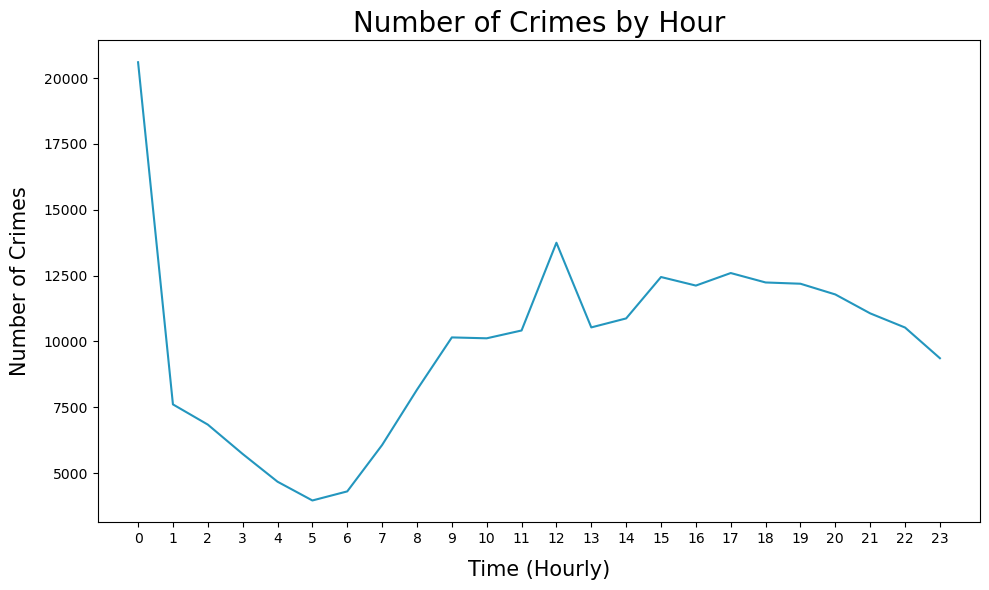

In [102]:
#| echo: false
# Round times down to nearest hour
time_data['hourly_time'] = time_data['Date'].dt.floor('H').dt.time

crime_counts = time_data['hourly_time'].value_counts().sort_index()
crime_counts = crime_counts.to_frame(name = 'Count').reset_index()

plt.rcParams["figure.figsize"] = [10, 6]
#plt.figure(figsize=(10, 6))
bx = sns.lineplot(x= crime_counts.index, y=crime_counts.Count, color = "#2396be")
step = len(crime_counts.index) // 24 
plt.xticks(range(0, len(crime_counts.index), step))
plt.xlabel('Time (Hourly)', fontsize = 15, labelpad=10)
plt.ylabel('Number of Crimes', fontsize = 15, labelpad=10)
plt.title('Number of Crimes by Hour', fontsize = 20)
plt.tight_layout()
plt.show()

I was also interested in analyzing rush hour time frames. Morning rush hour is ....

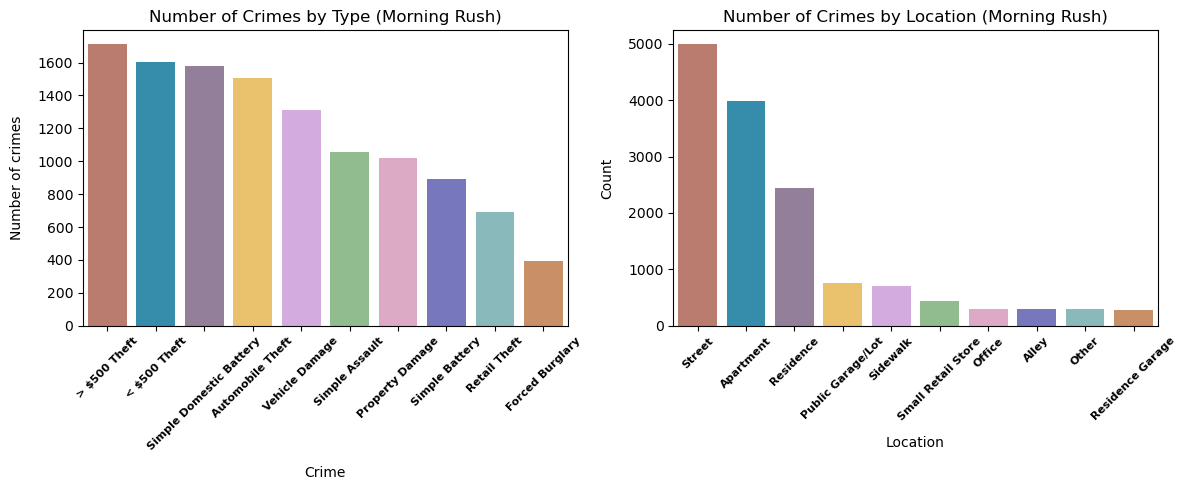

In [103]:
#| echo: false
morning_rush = time_data.loc[(time_data['Date'].dt.hour >= 6) & (time_data['Date'].dt.hour < 9)]
combination_mr = morning_rush.groupby(['Primary Type', 'Description']).size().reset_index(name='Count')
combination_mr = combination_mr.sort_values(by = 'Count', ascending = False).head(10)
combination_mr['Type'] = combination_mr['Primary Type'] + " " + combination_mr['Description']
mr_locations = morning_rush['Location Description'].value_counts().head(10)
locations_mr = mr_locations.to_frame(name = 'Count').reset_index()
plt.rcParams["figure.figsize"] = [5,3.5]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Adjust the figsize as needed

# Plotting the first graph on the first subplot (axes[0])
ax1 = sns.barplot(x=combination_mr.Type, y=combination_mr.Count, palette=colors, ax=axes[0])
ax1.set_xlabel('Crime', fontsize=10, labelpad=10)
ax1.set_xticklabels(labels=['> $500 Theft', '< $500 Theft', 'Simple Domestic Battery', 'Automobile Theft', 
                            'Vehicle Damage', 'Simple Assault', 'Property Damage', 'Simple Battery', 
                            'Retail Theft', 'Forced Burglary'], rotation=45, weight='bold', fontsize=8)
ax1.set_ylabel('Number of crimes', fontsize=10, labelpad=10)
ax1.set_title('Number of Crimes by Type (Morning Rush)', fontsize=12)
ax1.tick_params(axis='y', labelsize=10)
ax1.tick_params(axis='x', labelsize=8)

# Plotting the second graph on the second subplot (axes[1])
ax2 = sns.barplot(x=locations_mr.index, y=locations_mr.Count, palette=colors, ax=axes[1])
ax2.set_xlabel('Location', fontsize=10, labelpad=10)
ax2.set_xticklabels(labels=['Street', 'Apartment', 'Residence', 'Public Garage/Lot', 
                             'Sidewalk', 'Small Retail Store', 'Office', 'Alley', 'Other', 
                             'Residence Garage'], rotation=45, weight='bold', fontsize=8)
ax2.set_ylabel('Count', fontsize=10, labelpad=10)
ax2.set_title('Number of Crimes by Location (Morning Rush)', fontsize=12)
ax2.tick_params(axis='y', labelsize=10)
ax2.tick_params(axis='x', labelsize=8)

# Adjust layout and display the subplots
plt.tight_layout()
plt.show()

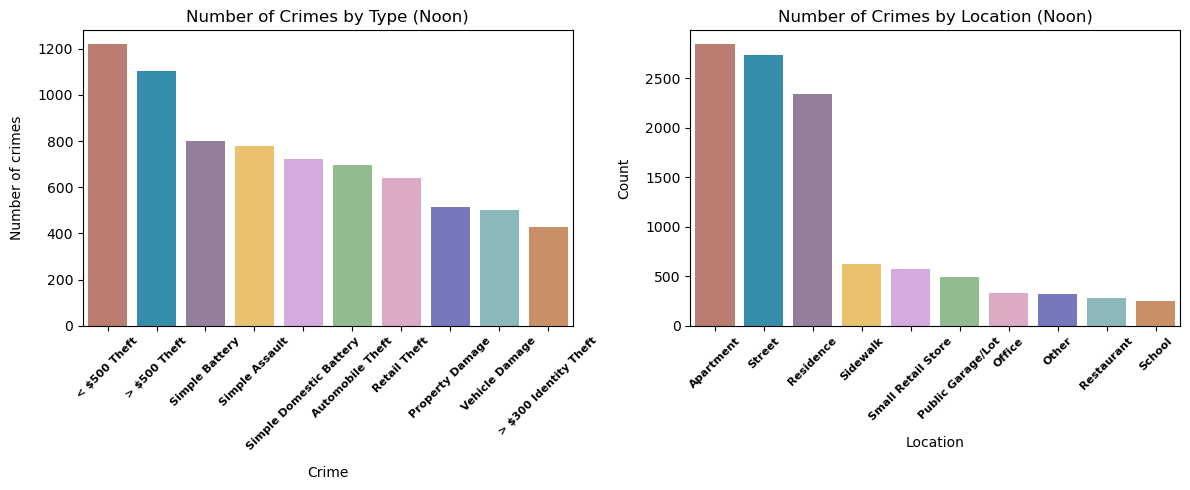

In [104]:
#| echo: false
noon = time_data.loc[time_data['Date'].dt.hour == 12]
combination_noon = noon.groupby(['Primary Type', 'Description']).size().reset_index(name='Count')
combination_noon = combination_noon.sort_values(by = 'Count', ascending = False).head(10)
combination_noon['Type'] = combination_noon['Primary Type'] + " " + combination_noon['Description']
noon_locations = noon['Location Description'].value_counts().head(10)
locations_noon = noon_locations.to_frame(name = 'Count').reset_index()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Adjust the figsize as needed

# Plotting the first graph on the first subplot (axes[0])
ax1 = sns.barplot(x=combination_noon.Type, y=combination_noon.Count, palette=colors, ax=axes[0])
ax1.set_xlabel('Crime', fontsize=10, labelpad=10)
ax1.set_xticklabels(labels=['< $500 Theft', '> $500 Theft', 'Simple Battery', 'Simple Assault', 
                            'Simple Domestic Battery', 'Automobile Theft', 'Retail Theft', 'Property Damage', 
                            'Vehicle Damage', '> $300 Identity Theft'], rotation=45, weight='bold', fontsize=8)
ax1.set_ylabel('Number of crimes', fontsize=10, labelpad=10)
ax1.set_title('Number of Crimes by Type (Noon)', fontsize=12)
ax1.tick_params(axis='y', labelsize=10)
ax1.tick_params(axis='x', labelsize=8)

# Plotting the second graph on the second subplot (axes[1])
ax2 = sns.barplot(x=locations_noon.index, y=locations_noon.Count, palette=colors, ax=axes[1])
ax2.set_xlabel('Location', fontsize=10, labelpad=10)
ax2.set_xticklabels(labels=['Apartment', 'Street', 'Residence', 'Sidewalk', 
                            'Small Retail Store', 'Public Garage/Lot', 'Office', 'Other', 
                            'Restaurant', 'School'], rotation=45, weight='bold', fontsize=8)
ax2.set_ylabel('Count', fontsize=10, labelpad=10)
ax2.set_title('Number of Crimes by Location (Noon)', fontsize=12)
ax2.tick_params(axis='y', labelsize=10)
ax2.tick_params(axis='x', labelsize=8)

# Adjust layout and display the subplots
plt.tight_layout()
plt.show()

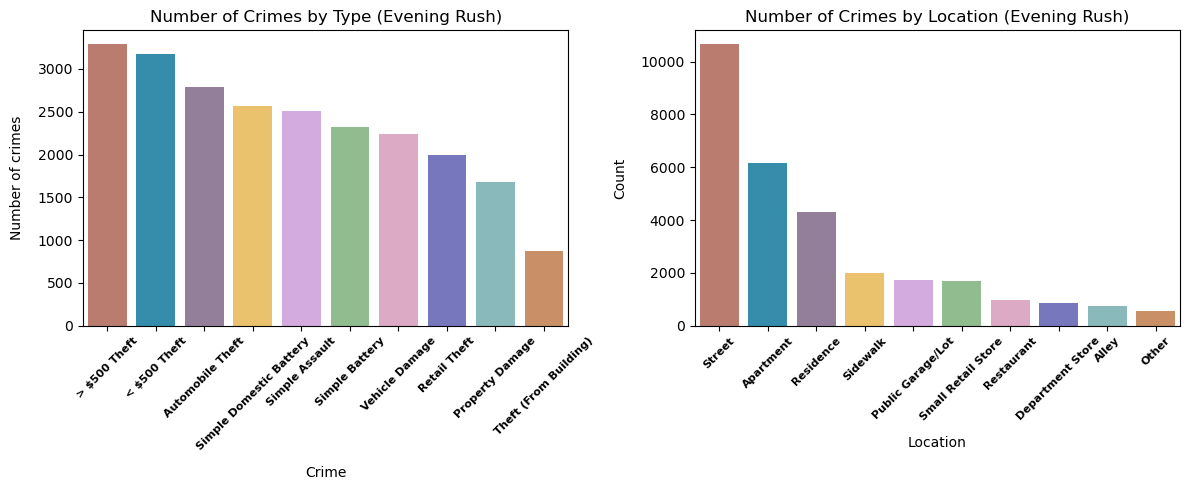

In [105]:
#| echo: false
evening_rush = time_data.loc[(time_data['Date'].dt.hour >= 16) & (time_data['Date'].dt.hour < 19)]
combination_er = evening_rush.groupby(['Primary Type', 'Description']).size().reset_index(name='Count')
combination_er = combination_er.sort_values(by = 'Count', ascending = False).head(10)
combination_er['Type'] = combination_er['Primary Type'] + " " + combination_er['Description']
er_locations = evening_rush['Location Description'].value_counts().head(10)
locations_er = er_locations.to_frame(name = 'Count').reset_index()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Adjust the figsize as needed

# Plotting the first graph on the first subplot (axes[0])
ax1 = sns.barplot(x=combination_er.Type, y=combination_er.Count, palette=colors, ax=axes[0])
ax1.set_xlabel('Crime', fontsize=10, labelpad=10)
ax1.set_xticklabels(labels=['> $500 Theft', '< $500 Theft', 'Automobile Theft', 'Simple Domestic Battery',
                             'Simple Assault', 'Simple Battery', 'Vehicle Damage', 
                             'Retail Theft', 'Property Damage', 'Theft (From Building)'], 
                     rotation=45, weight='bold', fontsize=8)
ax1.set_ylabel('Number of crimes', fontsize=10, labelpad=10)
ax1.set_title('Number of Crimes by Type (Evening Rush)', fontsize=12)
ax1.tick_params(axis='y', labelsize=10)
ax1.tick_params(axis='x', labelsize=8)

# Plotting the second graph on the second subplot (axes[1])
ax2 = sns.barplot(x=locations_er.index, y=locations_er.Count, palette=colors, ax=axes[1])
ax2.set_xlabel('Location', fontsize=10, labelpad=10)
ax2.set_xticklabels(labels=['Street', 'Apartment', 'Residence', 'Sidewalk', 'Public Garage/Lot', 
                             'Small Retail Store', 'Restaurant', 'Department Store', 'Alley', 'Other'], 
                     rotation=45, weight='bold', fontsize=8)
ax2.set_ylabel('Count', fontsize=10, labelpad=10)
ax2.set_title('Number of Crimes by Location (Evening Rush)', fontsize=12)
ax2.tick_params(axis='y', labelsize=10)
ax2.tick_params(axis='x', labelsize=8)

# Adjust layout and display the subplots
plt.tight_layout()
plt.show()

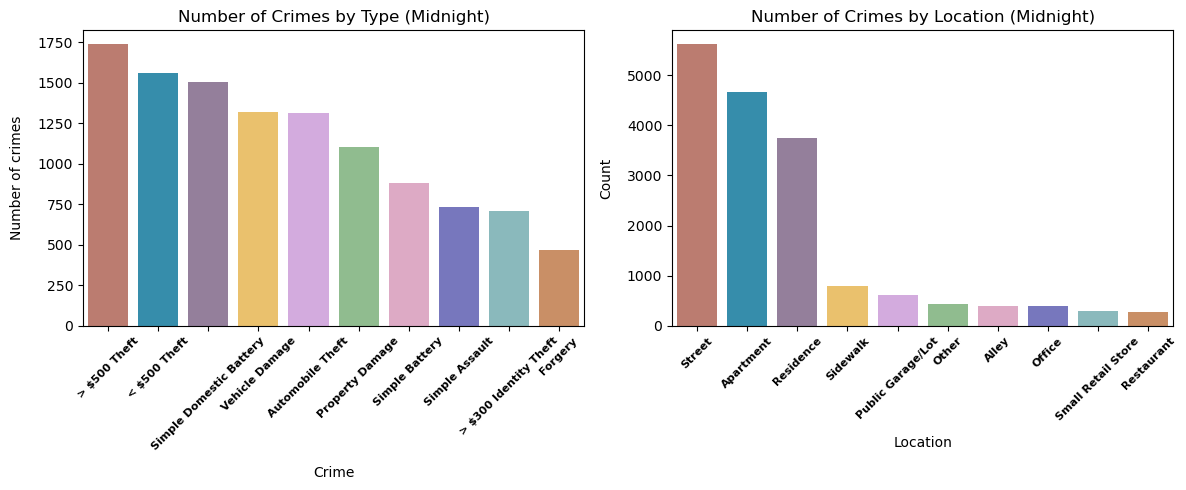

In [106]:
#| echo: false
midnight = time_data.loc[time_data['Date'].dt.hour == 0]
combination_midnight = midnight.groupby(['Primary Type', 'Description']).size().reset_index(name='Count')
combination_midnight = combination_midnight.sort_values(by = 'Count', ascending = False).head(10)
combination_midnight['Type'] = combination_midnight['Primary Type'] + " " + combination_midnight['Description']
midnight_locations = midnight['Location Description'].value_counts().head(10)
locations_midnight = midnight_locations.to_frame(name = 'Count').reset_index()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Adjust the figsize as needed

# Plotting the first graph on the first subplot (axes[0])
ax1 = sns.barplot(x=combination_midnight.Type, y=combination_midnight.Count, palette=colors, ax=axes[0])
ax1.set_xlabel('Crime', fontsize=10, labelpad=10)
ax1.set_xticklabels(labels=['> $500 Theft', '< $500 Theft', 'Simple Domestic Battery', 'Vehicle Damage', 
                             'Automobile Theft', 'Property Damage', 'Simple Battery', 'Simple Assault', 
                             '> $300 Identity Theft', 'Forgery'], rotation=45, weight='bold', fontsize=8)
ax1.set_ylabel('Number of crimes', fontsize=10, labelpad=10)
ax1.set_title('Number of Crimes by Type (Midnight)', fontsize=12)
ax1.tick_params(axis='y', labelsize=10)
ax1.tick_params(axis='x', labelsize=8)

# Plotting the second graph on the second subplot (axes[1])
ax2 = sns.barplot(x=locations_midnight.index, y=locations_midnight.Count, palette=colors, ax=axes[1])
ax2.set_xlabel('Location', fontsize=10, labelpad=10)
ax2.set_xticklabels(labels=['Street', 'Apartment', 'Residence', 'Sidewalk', 
                            'Public Garage/Lot', 'Other', 'Alley', 'Office', 
                            'Small Retail Store', 'Restaurant'], rotation=45, weight='bold', fontsize=8)
ax2.set_ylabel('Count', fontsize=10, labelpad=10)
ax2.set_title('Number of Crimes by Location (Midnight)', fontsize=12)
ax2.tick_params(axis='y', labelsize=10)
ax2.tick_params(axis='x', labelsize=8)

# Adjust layout and display the subplots
plt.tight_layout()
plt.show()

### Analysis 2
*By \<Grace Chang>*

Since I am conducting research on theft, I subset the data so that only data with the Primary Type “Theft” remained; therefore, I could perform my subsequent analyses on only the theft data. I firstly wanted to see how the types of theft varied across the seventy-seven government-delineated Chicago community areas. In order to perform this analysis, I looked for the top twelve community areas with the highest number of observations of theft crimes, and subset the data such that only the data for these twelve areas remained. I focused on only these twelve observations because I wanted to visualize for stakeholders which areas they should pay particular attention to in terms of how often theft crimes are observed there, and how types of theft crimes compare across those twelve areas. 
<br>In order to visualize these statistics, I decided on using a stacked bar-plot. Originally, I tried to use a series of line plots—one plot for each community area in the top twelve, featuring the number of thefts of a given type of theft during each month of the year—via the Seaborn FacetGrid method. This did not work as there was a drastic difference between the number of occurrences in certain categories of theft for some community areas during most of the months. As a result, the scale of the plots within the FacetGrid, while they were consistent, did not match up well with the scale of the lines plotted, and the visualization was difficult to view and interpret. The stacked bar-plot removed the month factor, but I realized by attempting the FacetGrid that the month did not matter much. The stacked bar-plot makes it easy to see the proportions of the various theft types and visually compares the frequencies for the different community areas.

Text(0.5, 1.0, 'Types of theft in each community area')

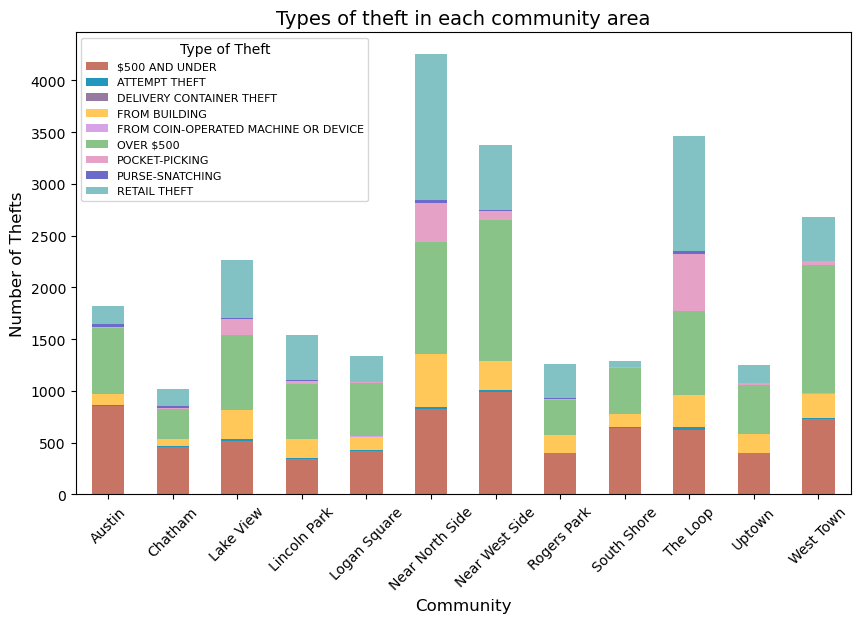

In [136]:
#| echo: false

# Finding the top 12 community areas that experience the most theft
top_12_community_areas = theft_community_data['Community Name'].value_counts().head(12)
top_12_areas_list = top_12_community_areas.index.to_list()
top_12_areas_data = theft_community_data[theft_community_data['Community Name'].isin(top_12_areas_list)]

theft_type = pd.crosstab(top_12_areas_data['Community Name'], top_12_areas_data['Description'])

# Color palette
colors = ["#c77464", "#2396be", "#967aa0", "#ffc858", "#d8a2e7", "#89c388", "#e6a1c6", "#6c6bc9", "#82c1c4", "#d98c55"]
sns.set_palette(sns.color_palette(colors))

# Stacked barplot
ax = theft_type.plot.bar(stacked = True, ylabel = 'Number of Thefts', figsize=(10, 6), xlabel = 'Community')
ax.tick_params(axis = 'both', labelsize = 10)
ax.tick_params(axis = 'x', labelrotation = 45)

# Labels for the plot
ax.legend(title = 'Type of Theft', fontsize=8, title_fontsize=10)
ax.set_xlabel('Community', fontsize=12)
ax.set_ylabel('Number of Thefts', fontsize=12)
ax.set_title('Types of theft in each community area', fontsize=14)

Based on this plot, I noticed that theft over 500 dollars dominates theft under 500 dollars in most of the districts, with a notable difference in the ‘West Town’ and ‘Near West Side’ areas, showing that theft of greater financial value is more common than that of less value—this is further supported by the percentages of each type of overall theft, where theft over 500 dollars accounts for 33%, and theft under 500 dollars around 28%. While this is not a significant difference, I concluded that financial theft in general is by far the most common type of theft. The plot also exhibits this trend, where theft of monetary assets account for the greatest proportion of thefts, and retail theft also being common. One surprising observation from this plot is that pick-pocketing only makes up a small part of thefts across the twelve community areas compared to retail theft and financial theft.
<br>Finally, I observed that the four areas with the most theft occurrences were concentrated in the same area—The Loop, Near North Side, Near West Side, and West Town border each other, and this region is also often described as downtown Chicago by visitors and residents. This observation implies that people should be particularly wary in these areas, especially seeing as they are popular areas to live and visit. Based on this context, I further questioned whether there was a relationship between the population density of a community area and the number of thefts in that area. In order to attack this problem, I created a dataset via merging that included the community area names, their corresponding numbers of thefts, and their population densities. I then utilized this dataset to plot a linear regression relating population density and number of thefts.

Text(0, 0.5, 'Number of Thefts')

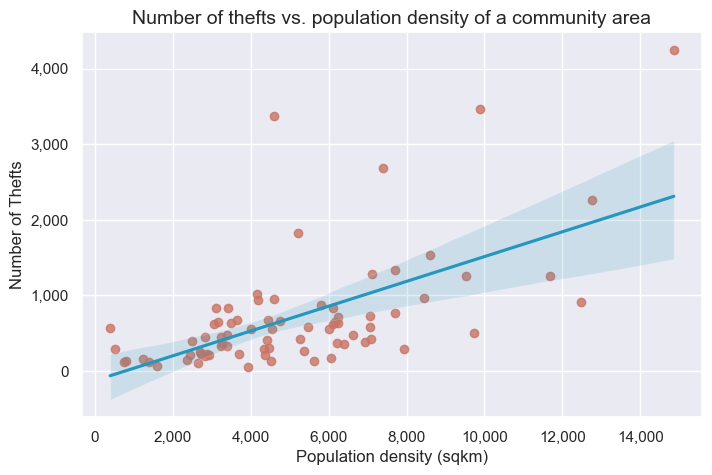

In [137]:
#| echo: false

# Correlate population density with crime
theft_counts_areas = pd.DataFrame(theft_community_data['Community Name'].value_counts())
theft_counts_areas = theft_counts_areas.reset_index()
theft_counts_areas.columns = ["Community Name", "Number of Thefts"]

community_areas['Community Name'] = community_areas['Community Name'].apply(lambda x:x.replace('(The) Loop[11]', 'The Loop'))

theft_counts_areas['Community Name'] = theft_counts_areas['Community Name'].astype(str)
theft_with_density = theft_counts_areas.merge(community_areas, left_on = 'Community Name', right_on = 'Community Name', how = 'left')

plt.rcParams['figure.figsize'] = (8, 5)
sns.set(font_scale = 1.5)
ax = sns.regplot(x = 'Density (sqkm)', y = 'Number of Thefts', data = theft_with_density, scatter_kws = {'color':'#c87464'}, line_kws = {'color':'#2596be'})

ax.set_title('Number of thefts vs. population density of a community area', fontsize=14)
ax.xaxis.set_major_formatter('{x:,.0f}')
ax.yaxis.set_major_formatter('{x:,.0f}')
ax.tick_params(axis = 'both', labelsize = 11)
ax.set_xlabel('Population density (sqkm)', fontsize=12)
ax.set_ylabel('Number of Thefts', fontsize=12)

In [138]:
#| echo: false

print('Community Areas Ranked by Population Density','\n',\
      (theft_with_density.sort_values(by = 'Density (sqkm)', ascending = False))[['Community Name', 'Density (sqkm)']].head(12),sep = '')

Community Areas Ranked by Population Density
     Community Name  Density (sqkm)
0   Near North Side        14863.58
4         Lake View        12752.44
15        Edgewater        12491.89
9       Rogers Park        11672.81
1          The Loop         9897.73
38      Albany Park         9732.13
10           Uptown         9516.37
6      Lincoln Park         8612.96
12       West Ridge         8435.36
55          Hermosa         7940.46
20   Belmont Cragin         7713.71
7      Logan Square         7707.48


It is important to see that while there is a general positive correlation, out of the top four community areas of interest that I discovered as exhibiting the highest numbers of theft, only two of them fall under the top twelve most population dense areas. I formulated this observation by comparing the top four with the top twelve because the top four community areas of interest were originally extracted from the top twelve community areas with the most theft overall. This observation implies that there are likely many extraneous variables in play affecting the number of thefts aside from simply the population density of an area, but based on the trend, we can assume that population density is still a significant independent variable. Seeing as the Near North Side (rank 1 in population density) and The Loop (rank 5 in population density) areas are much more dense than the West Town and Near West Side areas, but border these two areas to the right, a potential explanation could also be that there are many people who travel between these areas, and with them comes a spill-over of theft crimes into these two less population dense areas. 

### Analysis 3
*By \<Name of person doing the analysis>*

### Analysis 4
*By \<Paisley Lucier>*

The analysis question that I explored is: What are the associations between proportion of committed crimes that resulted in arrest and the police district of the occurence? 
In order to answer this question, I attempted many different approaches. I tried grouping the data in many ways to see if there were assocations between variables. 
Namely, I struggled with binning the data and effectively aggregating it. As 'Arrest' is a boolean value, I had to find representative and effective ways to bin the data, before landing on binning police districts by side of Chicago. Ultimately, within my analysis I still maintained nuance in regards to recommendations for specific districts. 
Firstly, I generally looked at the proportion of observations that resulted in arrest by each side of Chicago. 

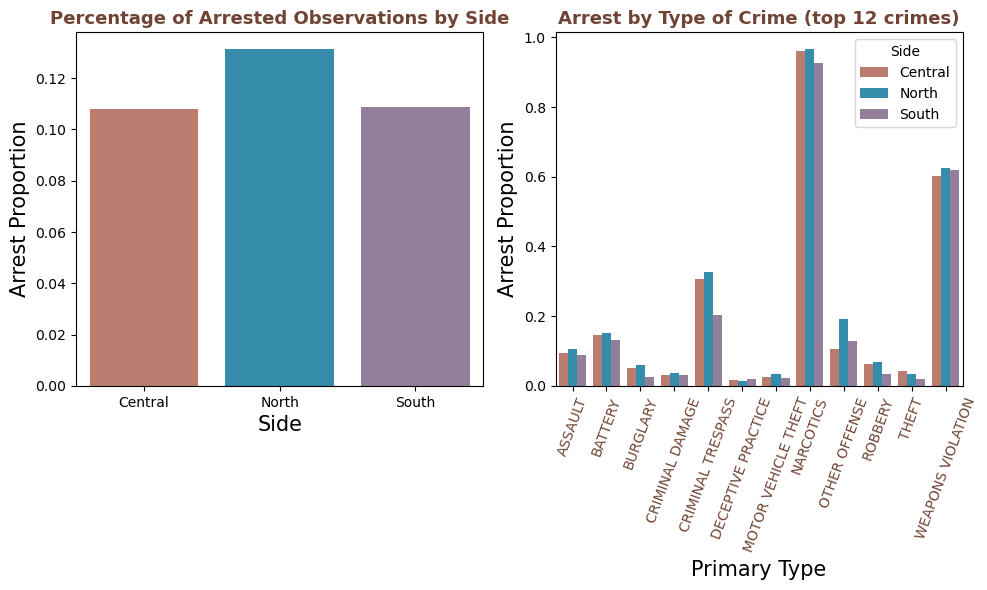

In [146]:
#| echo: false

plt.rcParams["figure.figsize"] = [10.00, 6]
plt.rcParams["figure.autolayout"] = True

f, axes = plt.subplots(1, 2)

grouped_sides = arrest_data.groupby(['Side'])
grouped_sides_m = grouped_sides.mean()

top_12_crimes = arrest_data.loc[((arrest_data['Primary Type'] == 'THEFT') | \
                               (arrest_data['Primary Type'] == 'BATTERY') | \
                               (arrest_data['Primary Type'] == 'CRIMINAL DAMAGE') | \
                               (arrest_data['Primary Type'] == 'MOTOR VEHICLE THEFT') | \
                               (arrest_data['Primary Type'] == 'ASSAULT') | \
                               (arrest_data['Primary Type'] == 'DECEPTIVE PRACTICE') | \
                               (arrest_data['Primary Type'] == 'OTHER OFFENSE') | \
                               (arrest_data['Primary Type'] == 'ROBBERY') | \
                               (arrest_data['Primary Type'] == 'WEAPONS VIOLATION') | \
                               (arrest_data['Primary Type'] == 'BURGLARY') | \
                               (arrest_data['Primary Type'] == 'NARCOTICS') | \
                               (arrest_data['Primary Type'] == 'CRIMINAL TRESPASS')), :]

grouped_side_type = top_12_crimes.groupby(['Side', 'Primary Type'])
grouped_side_type_m = grouped_side_type.mean().loc[:, 'Arrest']
grouped_side_type_m = grouped_side_type_m.reset_index() 

sns.barplot(data=grouped_sides_m, x=grouped_sides_m.index, y='Arrest', ax=axes[0])

axes[0].set_title("Percentage of Arrested Observations by Side",
                  fontdict = {'fontsize': 13,
                              'fontweight': 'bold',
                              'color': '#704434'})
axes[0].set_xlabel('Side', fontsize=15)
axes[0].set_ylabel('Arrest Proportion', fontsize=15)


sns.barplot(x='Primary Type',y='Arrest', hue='Side', data = grouped_side_type_m, ax=axes[1])

axes[1].set_xticklabels(axes[1].get_xticklabels(),rotation=70, fontdict = {
                              'color': '#704434'})
axes[1].set_title("Arrest by Type of Crime (top 12 crimes)",
                  fontdict = {'fontsize': 13,
                              'fontweight': 'bold',
                              'color': '#704434'})
axes[1].set_xlabel('Primary Type', fontsize=15)
axes[1].set_ylabel('Arrest Proportion', fontsize=15)

plt.show()

This generally shows the proportion of arrested crime across side. As we can see, the North side has the highest overall arrest proportion--higher than both the South and Central sides. However, it would be more enlightening to see the arrest proportion by type of crime: this is what the graph on the right shows.

The barplot on the right above shows the proportion of observations arrested for each of the 12 crimes with the most overall observances in the data, separated by the side the crime occurred in. Within this bar chart, we can see that the disparities in arrest prortion across sides prevail, though smaller in magnitude. This graph shows us that of the top 12 most frequently recorded crimes, the North Side's arrest rate is higher for 10 of them. Additionally, we can see that some crimes have much higher arrest proportions across sides than others: narcotics and weapons violations have higher arrest proportions than other crimes. Criminal tresspass appears to have the biggest disparity between the side with the highest arrest proportion and the side with the lowest, which I will further explore later.

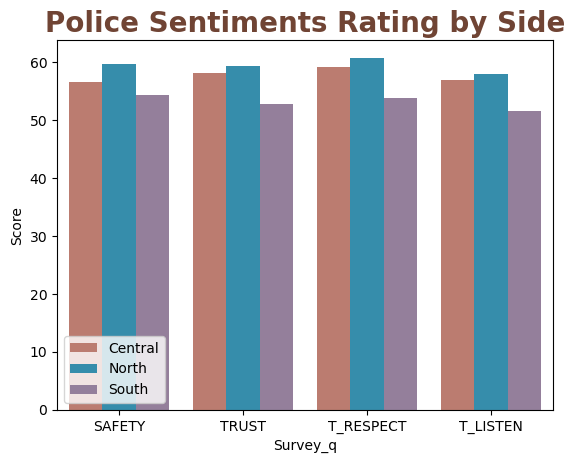

In [147]:
#| echo: false

plt.rcdefaults()
colors = ["#c77464", "#2396be", "#967aa0", "#ffc858", "#d8a2e7", "#89c388", "#e6a1c6", "#6c6bc9", "#82c1c4", "#d98c55"]

sns.set_palette(sns.color_palette(colors))

# Group by district
sentiments_2022_m = sentiments_2022.groupby(['DISTRICT']).mean()
sentiments_2022_m = sentiments_2022_m.reset_index()

# Add side column
sentiments_2022_m['Side'] = sentiments_2022_m['DISTRICT']
sentiments_2022_m['Side'] = sentiments_2022_m['Side'].map({4: 'South', 5: 'South', 6: 'South', 7: 'South', 22: 'South', \
                       11: "North", 14: 'North', 15: 'North', 16: 'North', 17: 'North', 19: 'North', 20: 'North',\
                       24: 'North', 25: 'North', 1: 'Central', 2: 'Central', 3: 'Central', 8: 'Central', \
                        9: 'Central', 10: 'Central', 12: 'Central', 13: 'Central', 18: 'Central'})

sentiments_2022_m_side = sentiments_2022_m.groupby(['Side']).mean()
sentiments_2022_m_side = sentiments_2022_m_side.reset_index()
sentiments_2022_m_side.drop(labels='DISTRICT', inplace = True, axis=1)
sentiments_2022_m_side_melted = pd.melt(sentiments_2022_m_side,id_vars = ['Side'],var_name = 'Survey_q',value_name = 'Score')

ax = sns.barplot(data=sentiments_2022_m_side_melted, x='Survey_q', y='Score', hue='Side')

ax.set_title("Police Sentiments Rating by Side",
                  fontdict = {'fontsize': 20,
                              'fontweight': 'bold',
                              'color': '#704434'})

plt.legend(loc='lower left')
plt.show()

The North side has a higher average sentiment score for each question. Much like many of the bar collections by side in the visualization of arrest proportion across side when separated by primary type seen above, the North side is highest, then the Central side follows, and then the lowest is the South side. We can see that there is little variation in score across the different survey questions for each of the sides, although the North side appears to have the largest lead on the Central side in its Safety score.

I next considered the association between arrest proportion and average sentiment score for each district for the top 12 crimes. The 5 crimes of ROBBERY (.658005), BATTERY (0.598168), THEFT (0.495089), ASSAULT (0.459407), and BURGLARY (0.442316) had the highest correlation between a district's average sentiment score rating and their arrest rate (with the next highest having a correlation coefficient of .26). I binned these five crimes by general type and visualized them below.

In [148]:
#| echo: false

sentiments_arrest_dis = sentiments_2022_m.copy()
sentiments_arrest_dis = sentiments_arrest_dis.set_index('DISTRICT')

sentiments_arrest_dis['avg_sent'] = (sentiments_arrest_dis['SAFETY'] + sentiments_arrest_dis['TRUST'] + \
                                    sentiments_arrest_dis['T_RESPECT'] + sentiments_arrest_dis['T_LISTEN']) / 4
sentiments_arrest_dis = sentiments_arrest_dis.drop(columns=['SAFETY', 'TRUST', 'T_RESPECT', 'T_LISTEN'])

grouped = pd.DataFrame(top_12_crimes.groupby(['District', 'Primary Type']).mean().loc[:, 'Arrest'])

def merge_sentiments(x):
    x = pd.merge(left=x, right=sentiments_arrest_dis.reset_index(), left_on='District', right_on='DISTRICT')
    return x


grouped_new = grouped.reset_index().groupby('Primary Type').apply(merge_sentiments)


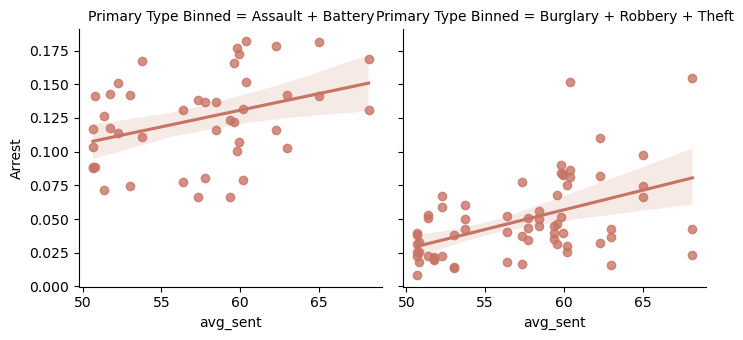

In [149]:
#| echo: false

grouped_new['Primary Type Binned'] = "None"
def bin_it(x):
    if (x['Primary Type'] == 'ASSAULT' or x['Primary Type'] == 'BATTERY'):
        x['Primary Type Binned'] = "Assault + Battery"
    elif (x['Primary Type'] == 'BURGLARY' or x['Primary Type'] == 'ROBBERY' or x['Primary Type'] == 'THEFT'):
        x['Primary Type Binned'] = "Burglary + Robbery + Theft"
    else:
        x['Primary Type Binned'] = x['Primary Type']
    return x
    
grouped_new = grouped_new.apply(bin_it, axis=1)
grouped_new = grouped_new.drop(columns = 'Primary Type')
grouped_new.reset_index()
grouped_new.groupby('Primary Type Binned')

a = sns.FacetGrid(grouped_new.loc[(grouped_new['Primary Type Binned']== 'Assault + Battery') \
                                  | (grouped_new['Primary Type Binned'] == 'Burglary + Robbery + Theft')], \
                  col = 'Primary Type Binned',col_wrap=3,height=3.5,aspect = 1)
a.map_dataframe(sns.regplot,x="avg_sent", y="Arrest")
plt.show()

As we can see, for the crime types that are assault and battery, as well as the crime types of burglary, robbery, and theft, there is a moderate, positive, and linear assocition between the proportion arrested and average sentiment for a district. 
Lastly, I wanted to take a look at which crime-district combinations had the highest disparity in arrest proportion. Below is a dataframe displaying the , for the top 12 crimes with the most occurences.

In [150]:
#| echo: false
grouped = pd.DataFrame(top_12_crimes.groupby(['Primary Type', 'District']).mean().loc[:, 'Arrest'])
grouped_reset = grouped.reset_index()

disparity_df = np.ones([grouped_reset['Primary Type'].nunique(), 4])
disparity_df = pd.DataFrame(disparity_df, columns=['Primary Type', 'District of Max Arrest Proportion', \
                                                   'District of Min Arrest Proportion', 'Difference'])
disparity_df['Primary Type'] = grouped_reset['Primary Type'].value_counts().index
disparity_df = disparity_df.set_index('Primary Type')

def get_disparity(x):
    maxx = x.Arrest.max()
    minn = x.Arrest.min()
    disparity_df.loc[x.loc[x['District'] == 1, 'Primary Type'], 'District of Max Arrest Proportion'] = x.loc[x.Arrest.idxmax(), 'District']
    disparity_df.loc[x.loc[x['District'] == 1, 'Primary Type'], 'District of Min Arrest Proportion'] = x.loc[x.Arrest.idxmin(), 'District']
    disparity_df.loc[x.loc[x['District'] == 1, 'Primary Type'], 'Difference'] = maxx - minn
    
grouped_reset.groupby('Primary Type').apply(get_disparity)

disparity_df.sort_values(by = 'Difference', ascending = False)

,District of Max Arrest Proportion,District of Min Arrest Proportion,Difference
Primary Type,,,
WEAPONS VIOLATION,18.0,17.0,0.516396
CRIMINAL TRESPASS,16.0,22.0,0.449882
OTHER OFFENSE,14.0,3.0,0.272351
ROBBERY,16.0,5.0,0.134063
NARCOTICS,19.0,6.0,0.116667
ASSAULT,1.0,12.0,0.085086
BURGLARY,18.0,4.0,0.083151
BATTERY,1.0,7.0,0.078671
THEFT,1.0,7.0,0.072987


From the dataframe above (sorted by the difference in arrest proportion), we can see that, of the top 12 crimes, weapons violation and criminal tresspass have the highest arrest disparity, followed by robbery and narcotics. These top 4 all have a difference of over 10%. 

## Conclusions & Recommendations
*What are the action items for the stakeholder(s) based on your analysis? Be as precise as possible. The stakeholder(s) are depending on you to come up with practically implementable recommendations, instead of having to think for themselves.*

*Do the stakeholder(s) need to be aware about some limitations of your analysis? Can your analysis be directly used by the stakeholder(s) to obtain the expected benefit / make decisions, or do they need to do some further analysis based on their own, or do they need to repeat your analysis on a more recent data for the results to be applicable?*

Our individual analyses answer the broader topic of how to promote personal and community safety and welfare within Chicago. This plays into people’s satisfaction with policing and how to improve these sentiments, along with suggestions on how people should look out for themselves when traveling or living in the city. When examining the various trends yielded by our analyses, it is clear that across theft, general crime, and CTA crime that rush hour and midnight are the most dangerous times. Additionally, theft is very common across Chicago, whether it be on the street, in residential homes, or transportation areas, so stakeholders should be vigilant of our possessions, and can feel less anxious about murder, for example, which only makes up 0.3% of total crimes. 

**Alyssa's recommendation**
<br>text

**Grace Chang's recommendation**
<br>Next, based on the analysis of theft crimes, it is recommended to stakeholders—anyone who frequents or resides in Chicago—that they should pay more attention to their personal belongings in the region consisting of The Loop, Near North Side, Near West Side, and West Town. This region is popular for travel, as it includes financial districts and tourist attractions such as the Magnificent Mile, the Bean, and more, thus there are many stakeholders who are affected by this result. Furthermore, seeing that 33% of all thefts are thefts of financial assets over 500 dollars, and 28% are thefts of under 500 dollars, it is essential to be attentive about one’s financial possessions. Meanwhile, pick-pocketing, for example, only represents a small percentage—5.16%—of total theft crimes, so stakeholders can be assured that this crime is less common, contrary to common assumptions that pick-pocketing is a heavy concern when it comes to theft.
<br>There are a few limitations that stakeholders should keep in mind: This analysis does not include motor vehicle theft, another common type of theft, because motor vehicle theft has its own subsets of theft types that clash with the general theft category or overwhelm it, such that it became difficult to perform deeper analysis on the general theft category. Additionally, within these community areas there are neighborhoods that can vary in crime rates, but these go beyond the scope of our research and dataset, so stakeholders should do further analysis on a particular neighborhood they are visiting.

**Grace Shao's recommendation**
<br>text

**Paisley's recommendation**
<br>In regards to the police stakeholders, police should allocate resources, as well as more research into demographic information and district needs to pinpoint the roots of the disparities in arrest rates across districts for the same type of crime--namely the crimes of weapons violations in districts 17 and 18, criminal tresspass in districts 22 and 16, robbery in districts 5 and 16, and narcotics in districts 6 and 19, which all have arrest proportion disparities of >10% across the named districts. 
<br>Particularly, as seen in the associations between a district's arrest proportion and it's sentiment rating, robbery has the highest correlation and also is in the top 5 crimes with the highest arrest disparity. Thus, police should allocate resources to prevention of robbery in district 5, as well as further consider their arrest tactics and get community input to aim for higher sentiment scores. (Note: District 5's lowest robbery arrest proportion is followed by district , and district ), so this recommendation extends to these districts.

## Appendix {-}

- **Alyssa & Grace S. address the previous year's findings**
- **Alyssa's rush hour analysis (perhaps say in the report that the grader should check appendix for further information**
